In [1]:

import pandas as pd
import numpy as np

import matplotlib as mpl
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

from tensorflow.keras.models import load_model

from tqdm import tqdm

In [2]:
from utils import utils

In [3]:
RANDOM_STATE = 35

mpl.rcParams['figure.figsize'] = (12, 10)
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

# Preprocessing

In [4]:
data_ts = pd.read_csv("dataset/processed_features.csv")


columns=['account_id', 'is_fraud', 'device_id', 'balance', 'processed_at',
       'age_range', 'number_of_selfies_sent', 'time_client', 'cash_out_type_1',
       'cash_out_type_2', 'cash_out_type_3', 'cash_out_type_6']

data_ts = data_ts[columns]

# the columns that pass the float16 limite, we gonna take them and turn and something
# that we can work using min max scaler

max_account = data_ts["account_id"].max()
max_device_id = data_ts["device_id"].max()
max_processed_at = data_ts["processed_at"].max()
max_time_client = data_ts["time_client"].max()

data_ts["account_id"] = data_ts["account_id"] / max_account
data_ts["device_id"] = data_ts["device_id"] / max_device_id
data_ts["processed_at"] = data_ts["processed_at"] / max_processed_at
data_ts["time_client"] = data_ts["time_client"] / max_time_client

# seconds to days

data_ts.time_client = data_ts.time_client / (60*60*24)

data_ts.head()

,account_id,is_fraud,device_id,balance,processed_at,age_range,number_of_selfies_sent,time_client,cash_out_type_1,cash_out_type_2,cash_out_type_3,cash_out_type_6
0,0.000000,0,0.0,0.000167,0.999813,0.0,5.0,1.785904e-07,1,0,0,0
1,0.000016,0,0.0,0.000533,0.998152,1.0,5.0,1.970170e-06,0,0,1,0
2,0.000016,0,0.0,0.000347,0.999702,1.0,5.0,2.456546e-06,0,0,1,0
3,0.000016,0,0.0,0.000572,0.998524,1.0,5.0,2.087007e-06,0,0,1,0
4,0.000016,0,0.0,0.000346,0.998629,1.0,5.0,2.119767e-06,0,0,1,0


In [5]:
#droping the target and the features weakly correlated to the target
data_to_encode = data_ts.copy().drop(["account_id", "processed_at", "number_of_selfies_sent", "cash_out_type_6"], axis=1)

Y = np.array(data_to_encode.pop("is_fraud"), dtype=np.float32)
X = np.array(data_to_encode, dtype=np.float32)

# Model

In [6]:
encoder = load_model("../api_fraud_detection/model/saved_models/bottleneck")

2021-12-13 17:14:45.784988: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [7]:
encoded_x = encoder.predict(X)

encoded_x.shape

(940935, 4)

In [8]:
features_train, features_val, labels_train, labels_val = train_test_split(encoded_x,  Y, 
                                                                          test_size = 0.01,  stratify=Y)
features_train, features_test, labels_train, labels_test = train_test_split(features_train, labels_train,
                                                                            test_size = 0.01,  stratify=labels_train)

clf = RandomForestClassifier(max_depth= 50, max_features= 'log2', min_samples_split= 2, 
                            n_estimators= 400, random_state=RANDOM_STATE, n_jobs= 3,
                            class_weight= "balanced_subsample", min_samples_leaf= 2, 
                            verbose=1, oob_score=True)

clf.fit(features_train, labels_train)

[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:  1.1min
[Parallel(n_jobs=3)]: Done 194 tasks      | elapsed:  4.2min
[Parallel(n_jobs=3)]: Done 400 out of 400 | elapsed:  8.6min finished


RandomForestClassifier(class_weight='balanced_subsample', max_depth=50,
                       max_features='log2', min_samples_leaf=2,
                       n_estimators=400, n_jobs=3, oob_score=True,
                       random_state=35, verbose=1)

In [9]:
X_pack = features_train, features_val
Y_pack = labels_train, labels_val

history = utils.compare_models(X_pack, Y_pack, clf)

[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:    1.9s
[Parallel(n_jobs=3)]: Done 194 tasks      | elapsed:    9.0s
[Parallel(n_jobs=3)]: Done 400 out of 400 | elapsed:   19.1s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:    0.0s
[Parallel(n_jobs=3)]: Done 194 tasks      | elapsed:    0.1s


F1 score - Train: 0.9995503881147263 / val: 0.9991763628263863
ROC AUC score - Train: 0.9997594232239678 / val: 0.8997339010111761
PR AUC score - val: 0.7531005813590049


[Parallel(n_jobs=3)]: Done 400 out of 400 | elapsed:    0.3s finished


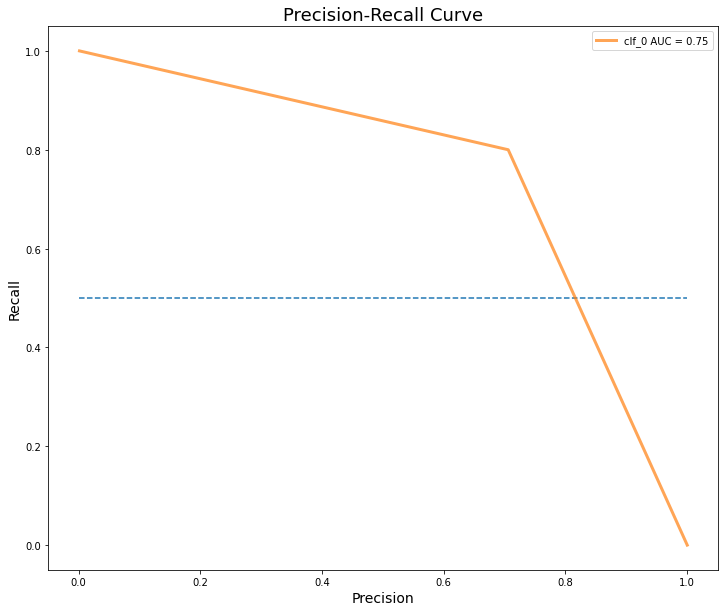

<function matplotlib.pyplot.show(close=None, block=None)>

In [10]:
plt.figure()
utils.plot_pr_curve(history)
plt.show

# Testing

In [11]:
X_pack_test = None, features_test
Y_pack_test = None, labels_test

history_test = utils.compare_models(X_pack_test, Y_pack_test, clf)

[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:    0.0s
[Parallel(n_jobs=3)]: Done 194 tasks      | elapsed:    0.1s
[Parallel(n_jobs=3)]: Done 400 out of 400 | elapsed:    0.2s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:    0.0s


ROC AUC score val: 0.8662366053829338
PR AUC score val: 0.6563550352911045


[Parallel(n_jobs=3)]: Done 194 tasks      | elapsed:    0.1s
[Parallel(n_jobs=3)]: Done 400 out of 400 | elapsed:    0.2s finished


# K-fold cross-val

In [12]:
indices_split, (X_test, Y_test) = X_pack, Y_pack = utils.split_data(encoded_x, Y,test_size=0.01,kfold=10,
                                                                    random_state=RANDOM_STATE)

for key, value in indices_split.items():
    
    print(f"{key} size train: {len(value[0])}, val: {len(value[1])}")

fold_0 size train: 838372, val: 93153
fold_1 size train: 838372, val: 93153
fold_2 size train: 838372, val: 93153
fold_3 size train: 838372, val: 93153
fold_4 size train: 838372, val: 93153
fold_5 size train: 838373, val: 93152
fold_6 size train: 838373, val: 93152
fold_7 size train: 838373, val: 93152
fold_8 size train: 838373, val: 93152
fold_9 size train: 838373, val: 93152


In [ ]:
clf_2 = RandomForestClassifier(max_depth= 50, max_features= 'log2', min_samples_split= 2, 
                                    n_estimators= 400, random_state=RANDOM_STATE, n_jobs= 3,
                                    class_weight= "balanced_subsample", min_samples_leaf= 2, 
                                    verbose=1, oob_score=True)

clfs = utils.train_model(clf_2, encoded_x, Y, indices_split)

Training clf 0


[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:   36.0s
[Parallel(n_jobs=3)]: Done 194 tasks      | elapsed:  2.4min
[Parallel(n_jobs=3)]: Done 400 out of 400 | elapsed:  4.9min finished


Training clf 1


[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:   33.5s


In [ ]:
history_cross = compare_models(X, Y, clfs, indices_split)

In [ ]:
utils.plot_pr_curve(history_cross)

In [ ]:
from joblib import dump

dump(clf, 'model_rfc.joblib') 